# Experiment 1

Compare error rates on **real data** for the following:

- No coding (trace reconstruction): BMALA improved vs Trellis BMA without lookahead vs Trellis BMA with lookahead

## Load real data

In [276]:
import seaborn as sns
import numpy as np
sns.set()

# from Levenshtein import distance, editops
from scipy.stats import mode
from tqdm import trange

print("Loading data...")
centers_list_chars = []
centers_str = []
# with open('TrainCenters.txt') as f:
with open('DataToProcess/TrainCenters.txt') as f:
    for l in f:
        centers_list_chars.append(list(l.split()[0]))
        centers_str.append(l.split()[0])
centers_list_chars = np.array(centers_list_chars)

traces_list_chars = []
traces_str = []
with open('DataToProcess/TrainClusters.txt') as f:
    for l in f:
        if l[0] == '=':
            traces_list_chars.append([])
            traces_str.append([])
        else:
            traces_list_chars[-1].append(np.array(list(l.split()[0])))
            traces_str[-1].append(l.split()[0])

def map2int(strarray, chars):
    maps = {}
    for i in range(len(chars)):
        maps[chars[i]] = i
    intarray = np.zeros_like(strarray, dtype = int)
    for i in range(len(strarray)):
        intarray[i] = maps[strarray[i]]
    return intarray


alphabet = ['A','C','G','T']
centers_list = []
traces_list = []
for i in trange(len(centers_list_chars), desc = "Creating dataset"):
    centers_list.append(map2int(centers_list_chars[i], alphabet))
    traces_list.append([])
    for j in range(len(traces_list_chars[i])):
        traces_list[-1].append(map2int(traces_list_chars[i][j], alphabet))

Loading data...


Creating dataset: 100%|█████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 664.31it/s]


## Functions to create plotting template

In [2]:
def make_plot_template(plot_type = "Hamming rate", xlim = (0,10), ylim = (0,50), figsize = (6,6)):
    import matplotlib 
    matplotlib.rc('xtick', labelsize=14) 
    matplotlib.rc('ytick', labelsize=14) 
    
    plt.figure(figsize = figsize)
    plt.xlabel("Number of traces",fontsize = 14)
    
    if plot_type == "Hamming rate":
        plt.ylabel("Normalized Hamming error rate",fontsize = 14)
    
    elif plot_type == "Information rate":
        plt.ylabel("Information rate (in bits/base)",fontsize = 14)
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.minorticks_on()
    plt.grid(b=True, which='major', linestyle='-')
    plt.grid(b=True, which='minor', linestyle='--',linewidth = 0.5)
    
    

def add_plot(data, N, keys, labels, plot_type = "Hamming rate", markers = None):
    
    if markers is None:
        markers = ["*","o","v","^","s","p","<",">","1","2","3","4","8","s","p","P",".",",","h",\
                   "H","+","x","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
    
    for idx, key in enumerate(keys):
        if plot_type == "Hamming rate":
            plt.plot(data["cluster_size"],data[key].mean(axis=1)/N, label = label[key], linewidth = 2, marker = markers[idx])
        elif plot_type == "Information rate":
            plt.plot(data["cluster_size"],data[key].mean(axis=1), label = label[key], linewidth = 2, marker = markers[idx])
    
    plt.legend(fontsize = 14)

## Learning IDS parameters

In [277]:
from Levenshtein import distance, editops
editops(centers_str[0],traces_str[0][0])
num_del = 0
num_ins = 0
num_sub = 0
num_traces = 0

for idx in trange(2000, desc = "Training IDS parameters"):
    seq = centers_str[idx]
    for tr in traces_str[idx]:
        num_traces += 1
        ops = editops(seq,tr)
        if len(ops) > 0:
            num_del += (np.array(ops)[:,0] == 'delete').sum()
            num_ins += (np.array(ops)[:,0] == 'insert').sum()
            num_sub += (np.array(ops)[:,0] == 'replace').sum()
            
p_del = num_del/(num_traces*len(centers_list[0]))
p_ins = num_ins/(num_traces*len(centers_list[0]))
p_sub = num_sub/(num_traces*len(centers_list[0]))
p_cor = 1.0 - (p_del+p_ins+p_sub)

Training IDS parameters: 100%|████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 658.61it/s]


In [255]:
print(p_del,p_ins,p_sub)

0.01875390320814797 0.01674582308540412 0.02140018195696255


## MultiD

In [5]:
from helper_functions import *
import pandas as pd
import numpy as np
from scipy.stats import mode

from conv_code import *
from coded_ids_multiD import *
from bma import *
from trellis_bma import *

import time

import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [ ]:
in_len = 110
N_cw = 110
redundancy = N_cw-in_len

A_in = 4
A_cw = 4

cc = conv_code()
G = np.array([[1]])
cc.quar_cc(G)
cc.make_trellis(in_len)
cc.make_encoder()
code_trellis_states = cc.trellis_states
code_trellis_edges = cc.trellis_edges
code_time_type = cc.time_type

num_traces = 1
# p_del = 0.011
# p_sub = 0.017
# p_ins = 0.02
max_drift = 10

ids_trellis = coded_ids_multiD(A_in, A_cw, code_trellis_states,code_trellis_edges, code_time_type,\
                 num_traces, p_del, p_sub, p_ins, max_drift, input_prior = None)

In [ ]:
# Real data
max_iters = 2000

errors = {}
errors["desc"] = "Experiment comparing error rates and IRs on real data without coding. \n\
Algorithms compared: MultiD bcjr.\n\
Compared on the clusters 2000 - 4000."

errors["multiD"] = []
errors["multiD_AIRs"] = []
errors["multiD_BORs"] = []
errors["cluster_size"] = [2,3]

ids_trellis1 = coded_ids_multiD(A_in, A_cw, code_trellis_states,code_trellis_edges, code_time_type,\
                     1, p_del, p_sub, p_ins, max_drift = 10, input_prior = None)

ids_trellis2 = coded_ids_multiD(A_in, A_cw, code_trellis_states,code_trellis_edges, code_time_type,\
                     2, p_del, p_sub, p_ins, max_drift = 10, input_prior = None)

ids_trellis3 = coded_ids_multiD(A_in, A_cw, code_trellis_states,code_trellis_edges, code_time_type,\
                     3, p_del, p_sub, p_ins, max_drift = 6, input_prior = None)


for cluster_size in errors["cluster_size"]:

    multiD_errors = []
    multiD_AIRs = []
    multiD_BORs = []

    
    for it in trange(2000,2000+max_iters):
        if len(traces_list[it]) == 0:
            print("Ignored empty cluster.")
            continue
        
        tr_list = traces_list[it][:cluster_size]
        
        traces = []
        for tr in tr_list:
            if np.abs(len(tr)-N_cw) <= max_drift:
                traces.append(tr)
            elif len(tr) > N_cw:
                idx_delete = np.random.choice(len(tr),len(tr)-N_cw-max_drift, replace = False)
                traces.append(np.delete(tr,idx_delete))
            else:
                idx_insert = np.random.choice(len(tr),N_cw-max_drift-len(tr), replace = False)
                traces.append(np.insert(tr,idx_insert,0))
                
        if len(traces) == 1:
            post_probs = ids_trellis1.bcjr(traces,cc.trellis_states[0][0],cc.trellis_states[-1])
            multiD_estimate = post_probs.argmax(axis=1)
            multiD_errors.append((multiD_estimate != centers_list[it]).sum())

            logp_y = ids_trellis.logp_y * 1.0
            P = np.zeros((in_len,4))
            P[np.arange(in_len),centers_list[it]] = 1
            ids_trellis1.bcjr(traces,cc.trellis_states[0][0],cc.trellis_states[-1], input_prior = P)
            logp_ylx = ids_trellis.logp_y * 1.0
        
        elif len(traces) == 2:
            post_probs = ids_trellis2.bcjr(traces,cc.trellis_states[0][0],cc.trellis_states[-1])
            multiD_estimate = post_probs.argmax(axis=1)
            multiD_errors.append((multiD_estimate != centers_list[it]).sum())

            logp_y = ids_trellis.logp_y * 1.0
            P = np.zeros((in_len,4))
            P[np.arange(in_len),centers_list[it]] = 1
            ids_trellis2.bcjr(traces,cc.trellis_states[0][0],cc.trellis_states[-1], input_prior = P)
        
        elif len(traces) == 3:
            post_probs = ids_trellis3.bcjr(traces,cc.trellis_states[0][0],cc.trellis_states[-1])
            multiD_estimate = post_probs.argmax(axis=1)
            multiD_errors.append((multiD_estimate != centers_list[it]).sum())

            logp_y = ids_trellis.logp_y * 1.0
            P = np.zeros((in_len,4))
            P[np.arange(in_len),centers_list[it]] = 1
            ids_trellis3.bcjr(traces,cc.trellis_states[0][0],cc.trellis_states[-1], input_prior = P)
        
        
        if (logp_ylx-logp_y)/in_len == -np.inf:
            raise ValueError("Infinity")
        
        multiD_AIRs.append((logp_ylx-logp_y)/in_len)
        multiD_BORs.append(BCJROR(post_probs, centers_list[it]))
        
        
    errors["multiD"].append(np.array(multiD_errors))
    errors["multiD_AIRs"].append(np.array(multiD_AIRs))
    errors["multiD_BORs"].append(np.array(multiD_BORs))
    
    print("MultiD error rate for a cluster size: ",cluster_size,"is ",np.array(multiD_errors).mean())
    print("MultiD AIRs for a cluster size: ",cluster_size,"is ",np.array(multiD_AIRs).mean())
    print("MultiD BORs for a cluster size: ",cluster_size,"is ",np.array(multiD_BORs).mean())
    
    time.sleep(0.5)

errors["multiD"] = np.array(errors["multiD"])
errors["multiD_AIRs"] = np.array(errors["multiD_AIRs"])
errors["multiD_BORs"] = np.array(errors["multiD_BORs"])

np.save("SavedData/real_uncoded_multiD.npy",errors)

## Trellis BMA

In [256]:
in_len = 110
N_cw = 110
redundancy = N_cw-in_len

A_in = 4
A_cw = 4

cc = conv_code()
G = np.array([[1]])
cc.quar_cc(G)
cc.make_trellis(in_len)
cc.make_encoder()
code_trellis_states = cc.trellis_states
code_trellis_edges = cc.trellis_edges
code_time_type = cc.time_type

num_traces = 1
# p_del = 0.011
# p_sub = 0.017
# p_ins = 0.02
max_drift = 15

ids_trellis = coded_ids_multiD(A_in, A_cw, code_trellis_states,code_trellis_edges, code_time_type,\
                 num_traces, p_del, p_sub, p_ins, max_drift, input_prior = None)

In [257]:
# Real data
max_iters = 100

errors = {}
errors["desc"] = "Experiment comparing error rates and information rates on real data without coding. \n\
Algorithms compared: Improved BMALA, Trellis BMA no look-ahead, Trellis BMA with look-ahead.\n\
Experiment run on the clusters 2000,10000 of the real data.\
"

errors["bma"] = []
errors["post_mul"] = []
errors["BOR_post_mul"] = []
errors["Tbma_noLA"] = []
errors["Tbma_LA"] = []
errors["BOR_Tbma_noLA"] = []
errors["BOR_Tbma_LA"] = []
errors["cluster_size"] = [2,6,10]

for cluster_size in errors["cluster_size"]:
    bma_errors = []
    post_mul_errors = []
    post_mul_BORs = []
    Tbma_noLA_errors = []
    Tbma_LA_errors = []
    Tbma_noLA_BORs = []
    Tbma_LA_BORs = []
    
    for it in trange(2000,2000+max_iters):
        if len(traces_list[it]) == 0:
            print("Encountered empty cluster, ignored it.")
            continue
        
        tr_list = traces_list[it][:cluster_size]
        
        bma_estimate = bmala_imp(N_cw,tr_list,2)
        
        post_mul_estimate, post_mul_probs = post_multiply(ids_trellis,tr_list,cc.trellis_states[0][0],\
                                                 cc.trellis_states[-1])
        
#         Tbma_noLA_estimate, Tbma_noLA_probs = trellis_bma(ids_trellis,tr_list,cc.trellis_states[0][0],\
#                                                  cc.trellis_states[-1],lookahead = False)
        Tbma_LA_estimate, Tbma_LA_probs = trellis_bma(ids_trellis,tr_list,cc.trellis_states[0][0],\
                                                 cc.trellis_states[-1],lookahead = True)
        
        bma_errors.append((centers_list[it] != bma_estimate).sum())
        
        post_mul_errors.append((centers_list[it] != post_mul_estimate).sum())
        post_mul_BORs.append(BCJROR(post_mul_probs, centers_list[it]))
        
#         Tbma_noLA_errors.append((centers_list[it] != Tbma_noLA_estimate).sum())
        Tbma_LA_errors.append((centers_list[it] != Tbma_LA_estimate).sum())
#         Tbma_noLA_BORs.append(BCJROR(Tbma_noLA_probs, centers_list[it]))
        Tbma_LA_BORs.append(BCJROR(Tbma_LA_probs, centers_list[it]))

    errors["bma"].append(np.array(bma_errors))
    errors["post_mul"].append(np.array(post_mul_errors))
    errors["BOR_post_mul"].append(np.array(post_mul_BORs))
#     errors["Tbma_noLA"].append(np.array(Tbma_noLA_errors))
    errors["Tbma_LA"].append(np.array(Tbma_LA_errors))
#     errors["BOR_Tbma_noLA"].append(np.array(Tbma_noLA_BORs))
    errors["BOR_Tbma_LA"].append(np.array(Tbma_LA_BORs))
    
    print("BMA error rate for a cluster size: ",cluster_size,"is ",np.array(bma_errors).mean())
    print("Post multiply error rate for a cluster size: ",cluster_size,"is ",np.array(post_mul_errors).mean())
    print("Post multiply BORs for a cluster size: ",cluster_size,"is ",np.array(post_mul_BORs).mean())
#     print("Trellis BMA (no LA) error rate for a cluster size: ",cluster_size,"is ",np.array(Tbma_noLA_errors).mean())
    print("Trellis BMA (with LA) error rate for a cluster size:",cluster_size,"is ",np.array(Tbma_LA_errors).mean())
#     print("Trellis BMA (no LA) BORs for a cluster size: ",cluster_size,"is ",np.array(Tbma_noLA_BORs).mean())
    print("Trellis BMA (with LA) BORs for a cluster size:",cluster_size,"is ",np.array(Tbma_LA_BORs).mean())
    
    time.sleep(0.5)

errors["bma"] = np.array(errors["bma"])
errors["post_mul"] = np.array(errors["post_mul"])
errors["BOR_post_mul"] = np.array(errors["BOR_post_mul"])
# errors["Tbma_noLA"] = np.array(errors["Tbma_noLA"])
errors["Tbma_LA"] = np.array(errors["Tbma_LA"])
# errors["BOR_Tbma_noLA"] = np.array(errors["BOR_Tbma_noLA"])
errors["BOR_Tbma_LA"] = np.array(errors["BOR_Tbma_LA"])

# np.save("SavedData/real_uncoded_rest.npy",errors)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.81it/s]


BMA error rate for a cluster size:  2 is  41.81
Post multiply error rate for a cluster size:  2 is  36.31
Post multiply BORs for a cluster size:  2 is  0.8502601816542221
Trellis BMA (with LA) error rate for a cluster size: 2 is  41.12
Trellis BMA (with LA) BORs for a cluster size: 2 is  -0.9631120721723161


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.44s/it]


BMA error rate for a cluster size:  6 is  10.91
Post multiply error rate for a cluster size:  6 is  28.84
Post multiply BORs for a cluster size:  6 is  0.7231233601239253
Trellis BMA (with LA) error rate for a cluster size: 6 is  12.31
Trellis BMA (with LA) BORs for a cluster size: 6 is  -0.7729309090134024


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:42<00:00,  2.23s/it]


BMA error rate for a cluster size:  10 is  8.59
Post multiply error rate for a cluster size:  10 is  27.93
Post multiply BORs for a cluster size:  10 is  0.37470943671618145
Trellis BMA (with LA) error rate for a cluster size: 10 is  8.02
Trellis BMA (with LA) BORs for a cluster size: 10 is  -0.6375984404997106


In [116]:
p_del+p_ins+p_sub

0.05998453951740137

Text(0.5, 1.0, 'BH constraint 1.')

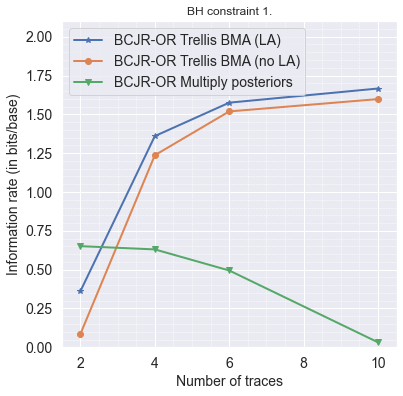

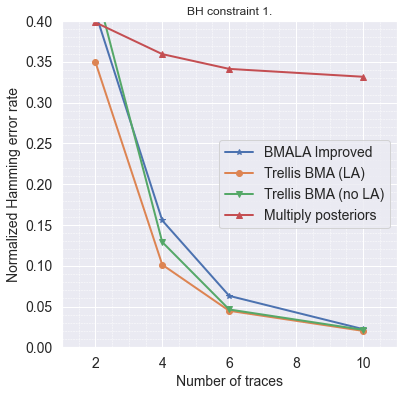

In [97]:
# errors_multiD = np.load("SavedData/real_uncoded_multiD.npy",allow_pickle = True).item()
# errors_rest = np.load("SavedData/real_uncoded_rest.npy",allow_pickle = True).item()

make_plot_template(plot_type = "Information rate", xlim = (1.5,10.5), ylim = (0,2.1))

keys = ["BOR_Tbma_LA", "BOR_Tbma_noLA","BOR_post_mul"]
label = {}
label["BOR_Tbma_noLA"] = "BCJR-OR Trellis BMA (no LA)"
label["BOR_Tbma_LA"] = "BCJR-OR Trellis BMA (LA)"
label["BOR_post_mul"] = "BCJR-OR Multiply posteriors"
add_plot(errors, 110, keys, label, "Information rate")
plt.title("BH constraint 1.")

make_plot_template(plot_type = "Hamming rate", xlim = (1,11), ylim = (0,0.4))

keys = ["bma","Tbma_LA", "Tbma_noLA","post_mul"]
label = {}
label["bma"] = "BMALA Improved"
label["Tbma_noLA"] = "Trellis BMA (no LA)"
label["Tbma_LA"] = "Trellis BMA (LA)"
label["post_mul"] = "Multiply posteriors"
add_plot(errors, 110, keys,  label, "Hamming rate")

plt.title("BH constraint 1.")

In [ ]:
errors_multiD = np.load("SavedData/real_uncoded_multiD.npy",allow_pickle = True).item()
errors_rest = np.load("SavedData/real_uncoded_rest.npy",allow_pickle = True).item()

make_plot_template(plot_type = "Information rate", xlim = (1.5,10.5), ylim = (0,2.1))

keys = ["multiD_AIRs", "multiD_BORs"]
label = {}
label["multiD_AIRs"] = "AIRs for multiD"
label["multiD_BORs"] = "BCJR-OR for multiD"
add_plot(errors_multiD, 110, keys,  label, "Information rate")

keys = ["BOR_Tbma_LA", "BOR_Tbma_noLA","BOR_post_mul"]
label = {}
label["BOR_Tbma_noLA"] = "BCJR-OR Trellis BMA (no LA)"
label["BOR_Tbma_LA"] = "BCJR-OR Trellis BMA (LA)"
label["BOR_post_mul"] = "BCJR-OR Multiply posteriors"
add_plot(errors_rest, 110, keys, label, "Information rate")
tikzplotlib.save("Plots/real_uncoded_IRs.tex")

make_plot_template(plot_type = "Hamming rate", xlim = (1,11), ylim = (0,0.4))

keys = ["multiD"]
label = {}
label["multiD"] = "MultiD"
add_plot(errors_multiD, 110, keys,  label, "Hamming rate")


keys = ["bma","Tbma_LA", "Tbma_noLA","post_mul"]
label = {}
label["bma"] = "BMALA Improved"
label["Tbma_noLA"] = "Trellis BMA (no LA)"
label["Tbma_LA"] = "Trellis BMA (LA)"
label["post_mul"] = "Multiply posteriors"
add_plot(errors_rest, 110, keys,  label, "Hamming rate")

import tikzplotlib
# tikzplotlib.save("test_plot.tex")


# Coded error rates

In [278]:
in_len = 100
N_cw = 110
redundancy = N_cw-in_len
redundant_positions = np.linspace(0, in_len-1, redundancy+2, dtype='int')[1:-1]
# redundant_positions = np.random.choice(in_len, size = redundancy, replace = False)
A_in = 4
A_cw = 4

num_traces = 1
# p_del = 0.011
# p_sub = 0.017
# p_ins = 0.02
max_drift = 15

# Real data
max_iters = 100

errors = {}
errors["desc"] = "Experiment comparing error rates and information rates on real data without coding. \n\
Algorithms compared: Improved BMALA, Trellis BMA no look-ahead, Trellis BMA with look-ahead.\n\
Experiment run on the clusters 2000,10000 of the real data.\
"

# errors["bma"] = []
errors["post_mul"] = []
errors["BOR_post_mul"] = []
errors["Tbma_LA"] = []
errors["BOR_Tbma_LA"] = []
errors["cluster_size"] = [2,4,10]
    
for it in trange(2100,2100+max_iters):
# for it in [2110]:
    
    if len(traces_list[it]) == 0:
        print("Encountered empty cluster, ignored it.")
        continue

    in_seq = np.random.choice(4,size=in_len)       # first generate a random input sequence

    cc = conv_code()
    G = np.array([[1],[1]])
    cc.quar_cc(G)
    cc.make_trellis(in_len)
    cc.puncture(redundancy=redundancy, redundant_positions=redundant_positions)
    cc.make_encoder()
    encoded_seq = cc.encode(in_seq)
    coset = np.mod(centers_list[it]-encoded_seq,4)   # determine appropriate coset vector 
    cc.add_coset(coset)

    code_trellis_states = cc.trellis_states
    code_trellis_edges = cc.trellis_edges
    code_time_type = cc.time_type

    ids_trellis = coded_ids_multiD(A_in, A_cw, code_trellis_states,code_trellis_edges, code_time_type,\
             num_traces, p_del, p_sub, p_ins, max_drift, input_prior = None)

    post_mul_errors = []
    post_mul_BORs = []
    Tbma_noLA_errors = []
    Tbma_LA_errors = []
    Tbma_noLA_BORs = []
    Tbma_LA_BORs = []

    for cluster_size in errors["cluster_size"]:

        tr_list = traces_list[it][:cluster_size]

#         bma_estimate = bmala_imp(N_cw,tr_list,2)

        post_mul_estimate, post_mul_probs = post_multiply(ids_trellis,tr_list,cc.trellis_states[0][0],\
                                                 cc.trellis_states[-1])
    
        Tbma_LA_estimate, Tbma_LA_probs = trellis_bma(ids_trellis,tr_list,cc.trellis_states[0][0],\
                                                 cc.trellis_states[-1],lookahead = True)

#         bma_errors.append((centers_list[it] != bma_estimate).sum())
        
        Tbma_LA_probs = np.array(Tbma_LA_probs)
        
        post_mul_errors.append((in_seq != post_mul_estimate).sum())
        post_mul_BORs.append(BCJROR(post_mul_probs, in_seq))

        Tbma_LA_errors.append((in_seq != Tbma_LA_estimate).sum())
        Tbma_LA_BORs.append(BCJROR(Tbma_LA_probs, in_seq))
        
#         if Tbma_LA_BORs[-1] < 0:
#             cc.make_encoder()
#             temp = np.ones(110, dtype = int)
#             temp[redundant_positions] = -1
#             print("True:",centers_list[it]*temp)
#             print("Deci:",cc.encode(Tbma_LA_estimate)*temp)
        

#     errors["bma"].append(np.array(bma_errors))
    errors["post_mul"].append(np.array(post_mul_errors))
    errors["BOR_post_mul"].append(np.array(post_mul_BORs))
    
    errors["Tbma_LA"].append(np.array(Tbma_LA_errors))
    errors["BOR_Tbma_LA"].append(np.array(Tbma_LA_BORs))
    
#     print("BMA error rate for a cluster size: ",cluster_size,"is ",np.array(bma_errors).mean())
#     print("Post multiply error rate for a cluster size: ",cluster_size,"is ",np.array(post_mul_errors).mean())
#     print("Post multiply BORs for a cluster size: ",cluster_size,"is ",np.array(post_mul_BORs).mean())
#     print("Trellis BMA (no LA) error rate for a cluster size: ",cluster_size,"is ",np.array(Tbma_noLA_errors).mean())
#     print("Trellis BMA (with LA) error rate for a cluster size:",cluster_size,"is ",np.array(Tbma_LA_errors).mean())
#     print("Trellis BMA (no LA) BORs for a cluster size: ",cluster_size,"is ",np.array(Tbma_noLA_BORs).mean())
#     print("Trellis BMA (with LA) BORs for a cluster size:",cluster_size,"is ",np.array(Tbma_LA_BORs).mean())
    
    time.sleep(0.5)
    
    
# errors["bma"] = np.array(errors["bma"])
errors["post_mul"] = np.array(errors["post_mul"])
errors["BOR_post_mul"] = np.array(errors["BOR_post_mul"])
errors["Tbma_LA"] = np.array(errors["Tbma_LA"])
errors["BOR_Tbma_LA"] = np.array(errors["BOR_Tbma_LA"])
# np.save("SavedData/real_uncoded_rest.npy",errors)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [12:50<00:00,  7.70s/it]


In [262]:
IRfromHR(errors["Tbma_LA"].mean(axis=0)/100)

array([1.71, 1.93])

In [261]:
print(errors["post_mul"].mean(axis=0))
print(errors["BOR_post_mul"].mean(axis=0))
print(errors["Tbma_LA"].mean(axis=0))
print(errors["BOR_Tbma_LA"].mean(axis=0))

[4.31 1.81]
[1.82 1.91]
[3.77 0.72]
[1.57 1.86]


In [251]:
errors["BOR_Tbma_LA"]

array([[ 1.99,  2.  ],
       [ 1.9 ,  2.  ],
       [ 1.97,  2.  ],
       [ 1.89,  1.56],
       [ 1.96,  2.  ],
       [ 1.98,  2.  ],
       [ 2.  ,  2.  ],
       [ 2.  ,  2.  ],
       [ 1.9 ,  2.  ],
       [ 2.  ,  2.  ],
       [ 1.87,  2.  ],
       [ 2.  ,  2.  ],
       [ 1.99,  2.  ],
       [ 1.4 ,  1.4 ],
       [ 1.99,  1.94],
       [ 1.67,  1.8 ],
       [ 1.9 ,  2.  ],
       [ 1.99,  2.  ],
       [ 1.72,  1.72],
       [ 2.  ,  2.  ],
       [ 1.88,  2.  ],
       [ 1.98,  2.  ],
       [ 2.  ,  2.  ],
       [ 1.76,  2.  ],
       [ 1.97,  2.  ],
       [ 2.  ,  2.  ],
       [ 1.94,  2.  ],
       [ 2.  ,  2.  ],
       [ 2.  ,  2.  ],
       [ 1.98,  2.  ],
       [ 2.  ,  2.  ],
       [ 1.85,  2.  ],
       [ 2.  ,  2.  ],
       [ 2.  ,  2.  ],
       [ 1.97,  1.79],
       [ 2.  , -1.78],
       [ 1.47, -2.75],
       [ 1.97,  2.  ],
       [ 1.96,  2.  ],
       [ 1.92,  1.94],
       [ 1.99,  2.  ],
       [ 1.88,  2.  ],
       [ 1.99,  2.  ],
       [ 1.

In [109]:
in_len = 100
N_cw = 110
redundancy = N_cw-in_len

A_in = 4
A_cw = 4

num_traces = 1
# p_del = 0.011
# p_sub = 0.017
# p_ins = 0.02
max_drift = 15


# Real data
max_iters = 100

errors = {}
errors["desc"] = "Experiment comparing error rates and information rates on real data without coding. \n\
Algorithms compared: Improved BMALA, Trellis BMA no look-ahead, Trellis BMA with look-ahead.\n\
Experiment run on the clusters 2000,10000 of the real data.\
"

# errors["bma"] = []
errors["post_mul"] = []
errors["BOR_post_mul"] = []
errors["Tbma_noLA"] = []
errors["Tbma_LA"] = []
errors["BOR_Tbma_noLA"] = []
errors["BOR_Tbma_LA"] = []
errors["cluster_size"] = [2,4,6,10]

    
for it in trange(2100,2100+max_iters):
    
    if len(traces_list[it]) == 0:
        print("Encountered empty cluster, ignored it.")
        continue

    in_seq = np.random.choice(4,size=in_len)       # first generate a random input sequence

    cc = conv_code()
    G = np.array([[1],[1]])
    cc.quar_cc(G)
    cc.make_trellis(in_len)
    cc.puncture(redundancy=redundancy)
    cc.make_encoder()
    encoded_seq = cc.encode(in_seq)
    coset = np.mod(centers_list[it]-encoded_seq,4)   # determine appropriate coset vector 
    cc.add_coset(coset)

    code_trellis_states = cc.trellis_states
    code_trellis_edges = cc.trellis_edges
    code_time_type = cc.time_type

    ids_trellis = coded_ids_multiD(A_in, A_cw, code_trellis_states,code_trellis_edges, code_time_type,\
             num_traces, p_del, p_sub, p_ins, max_drift, input_prior = None)

    post_mul_errors = []
    post_mul_BORs = []
    Tbma_noLA_errors = []
    Tbma_LA_errors = []
    Tbma_noLA_BORs = []
    Tbma_LA_BORs = []
    

    for cluster_size in errors["cluster_size"]:

        tr_list = traces_list[it][:cluster_size]

#         bma_estimate = bmala_imp(N_cw,tr_list,2)

        post_mul_estimate, post_mul_probs = post_multiply(ids_trellis,tr_list,cc.trellis_states[0][0],\
                                                 cc.trellis_states[-1])

        Tbma_noLA_estimate, Tbma_noLA_probs = trellis_bma(ids_trellis,tr_list,cc.trellis_states[0][0],\
                                                 cc.trellis_states[-1],lookahead = False)
        Tbma_LA_estimate, Tbma_LA_probs = trellis_bma(ids_trellis,tr_list,cc.trellis_states[0][0],\
                                                 cc.trellis_states[-1],lookahead = True)

#         bma_errors.append((centers_list[it] != bma_estimate).sum())

        post_mul_errors.append((in_seq != post_mul_estimate).sum())
        post_mul_BORs.append(BCJROR(post_mul_probs, in_seq))

        Tbma_noLA_errors.append((in_seq != Tbma_noLA_estimate).sum())
        Tbma_LA_errors.append((in_seq != Tbma_LA_estimate).sum())
        Tbma_noLA_BORs.append(BCJROR(Tbma_noLA_probs, in_seq))
        Tbma_LA_BORs.append(BCJROR(Tbma_LA_probs, in_seq))

#     errors["bma"].append(np.array(bma_errors))
    errors["post_mul"].append(np.array(post_mul_errors))
    errors["BOR_post_mul"].append(np.array(post_mul_BORs))
    errors["Tbma_noLA"].append(np.array(Tbma_noLA_errors))
    errors["Tbma_LA"].append(np.array(Tbma_LA_errors))
    errors["BOR_Tbma_noLA"].append(np.array(Tbma_noLA_BORs))
    errors["BOR_Tbma_LA"].append(np.array(Tbma_LA_BORs))
    
#     print("BMA error rate for a cluster size: ",cluster_size,"is ",np.array(bma_errors).mean())
#     print("Post multiply error rate for a cluster size: ",cluster_size,"is ",np.array(post_mul_errors).mean())
#     print("Post multiply BORs for a cluster size: ",cluster_size,"is ",np.array(post_mul_BORs).mean())
#     print("Trellis BMA (no LA) error rate for a cluster size: ",cluster_size,"is ",np.array(Tbma_noLA_errors).mean())
#     print("Trellis BMA (with LA) error rate for a cluster size:",cluster_size,"is ",np.array(Tbma_LA_errors).mean())
#     print("Trellis BMA (no LA) BORs for a cluster size: ",cluster_size,"is ",np.array(Tbma_noLA_BORs).mean())
#     print("Trellis BMA (with LA) BORs for a cluster size:",cluster_size,"is ",np.array(Tbma_LA_BORs).mean())
    
    time.sleep(0.5)
    
    
# errors["bma"] = np.array(errors["bma"])
errors["post_mul"] = np.array(errors["post_mul"])
errors["BOR_post_mul"] = np.array(errors["BOR_post_mul"])
errors["Tbma_noLA"] = np.array(errors["Tbma_noLA"])
errors["Tbma_LA"] = np.array(errors["Tbma_LA"])
errors["BOR_Tbma_noLA"] = np.array(errors["BOR_Tbma_noLA"])
errors["BOR_Tbma_LA"] = np.array(errors["BOR_Tbma_LA"])

# np.save("SavedData/real_uncoded_rest.npy",errors)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [17:08<00:00, 10.29s/it]


In [110]:
print("Post multiply errors",errors["post_mul"].mean(axis=0))
print("TBMA no LA errors",errors["Tbma_noLA"].mean(axis=0))
print("TBMA LA errors",errors["Tbma_LA"].mean(axis=0))

print("Post multiply BORs",errors["BOR_post_mul"].mean(axis=0))
print("TBMA no LA BORs",errors["BOR_Tbma_noLA"].mean(axis=0))
print("TBMA LA BORs",errors["BOR_Tbma_LA"].mean(axis=0))


Post multiply errors [9.02 4.47 3.02 1.81]
TBMA no LA errors [20.34  8.12  5.61  2.85]
TBMA LA errors [8.65 2.48 0.97 0.47]
Post multiply BORs [1.64652462 1.81350686 1.8571756  1.90070225]
TBMA no LA BORs [0.98305045 1.41668231 1.36015684 1.46236381]
TBMA LA BORs [1.59524071 1.81903845 1.90146653 1.91957899]


In [107]:
def make_plot_template(plot_type = "Hamming rate", xlim = (0,10), ylim = (0,50), figsize = (6,6)):
    import matplotlib 
    matplotlib.rc('xtick', labelsize=14) 
    matplotlib.rc('ytick', labelsize=14) 
    
    plt.figure(figsize = figsize)
    plt.xlabel("Number of traces",fontsize = 14)
    
    if plot_type == "Hamming rate":
        plt.ylabel("Normalized Hamming error rate",fontsize = 14)
    
    elif plot_type == "Information rate":
        plt.ylabel("Information rate (in bits/base)",fontsize = 14)
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.minorticks_on()
    plt.grid(b=True, which='major', linestyle='-')
    plt.grid(b=True, which='minor', linestyle='--',linewidth = 0.5)
    
    

def add_plot(data, N, keys, labels, plot_type = "Hamming rate", markers = None):
    
    if markers is None:
        markers = ["*","o","v","^","s","p","<",">","1","2","3","4","8","s","p","P",".",",","h",\
                   "H","+","x","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
    
    for idx, key in enumerate(keys):
        if plot_type == "Hamming rate":
            plt.plot(data["cluster_size"],data[key].mean(axis=0)/N, label = label[key], linewidth = 2, marker = markers[idx])
        elif plot_type == "Information rate":
            plt.plot(data["cluster_size"],data[key].mean(axis=0), label = label[key], linewidth = 2, marker = markers[idx])
    
    plt.legend(fontsize = 14)

In [232]:
def IRfromHR(p_error):
    IR = 2*np.ones_like(p_error)
    p_temp = p_error[p_error!=0]
    IR[p_error != 0] = 2 + (1-p_temp)*np.log2(1-p_temp) + p_temp*np.log2(p_temp/3)
    
    return IR

In [33]:
errors["Tbma_LA"].mean(axis=0)/100

array([0.0873, 0.0441, 0.0243, 0.0097])

In [36]:
IRfromHR(errors["Tbma_LA"].mean(axis=0)/in_len)

array([0.54328465, 1.13235343, 1.45887278, 1.74533657])

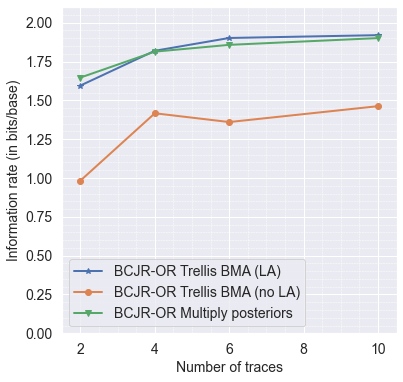

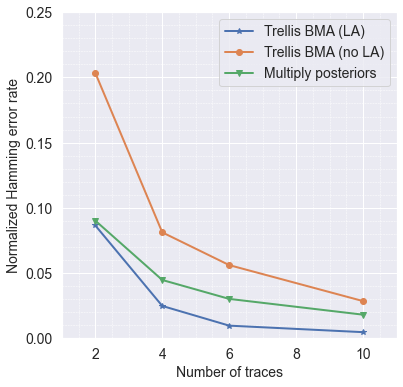

In [111]:
make_plot_template(plot_type = "Information rate", xlim = (1.5,10.5), ylim = (0,2.1))

# keys = ["multiD_AIRs", "multiD_BORs"]
# label = {}
# label["multiD_AIRs"] = "AIRs for multiD"
# label["multiD_BORs"] = "BCJR-OR for multiD"
# add_plot(errors_multiD, 110, keys,  label, "Information rate")

keys = ["BOR_Tbma_LA", "BOR_Tbma_noLA","BOR_post_mul"]
label = {}
label["BOR_Tbma_noLA"] = "BCJR-OR Trellis BMA (no LA)"
label["BOR_Tbma_LA"] = "BCJR-OR Trellis BMA (LA)"
label["BOR_post_mul"] = "BCJR-OR Multiply posteriors"
add_plot(errors, 100, keys, label, "Information rate")
plt.plot()
# tikzplotlib.save("Plots/real_uncoded_IRs.tex")

make_plot_template(plot_type = "Hamming rate", xlim = (1,11), ylim = (0,0.25))

# keys = ["multiD"]
# label = {}
# label["multiD"] = "MultiD"
# add_plot(errors_multiD, 110, keys,  label, "Hamming rate")


keys = ["Tbma_LA", "Tbma_noLA","post_mul"]
label = {}
label["bma"] = "BMALA Improved"
label["Tbma_noLA"] = "Trellis BMA (no LA)"
label["Tbma_LA"] = "Trellis BMA (LA)"
label["post_mul"] = "Multiply posteriors"
add_plot(errors, 100, keys,  label, "Hamming rate")